## Starbucks Ad Analysis
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset used was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

The task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, the goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provided to candidates see the [instructions available here](./Assignment.pdf).

We want to explore the data and different optimization strategies.

#### From past data

We know there are four possible outomes:

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

Table of actual promotion vs. predicted promotion customers

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well the promotion strategy will work in the future. 


In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


#### Exploring the data

In [2]:
train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [3]:
train_data.duplicated().sum()

0

No missing values and no duplicated records.

In [4]:
train_data['Promotion'] = train_data['Promotion'].map({'No':0, 'Yes':1})

In [5]:
train_data.iloc[:,1:].describe()

,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,0.501147,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,0.500002,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,0.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,1.000000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,1.000000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,1.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


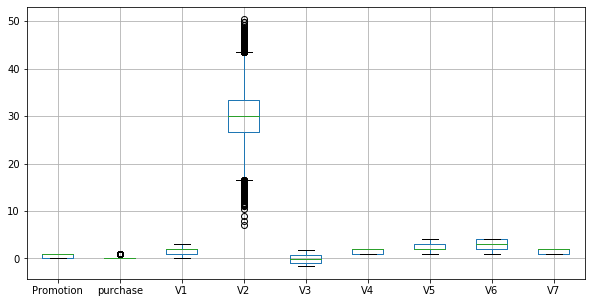

In [6]:
plt.figure(figsize=(10,5))
train_data.iloc[:,1:].boxplot();

Feature V2 has outliers (considering an outlier as values above and below 1.5 * IQR, Inter Quartile Range).

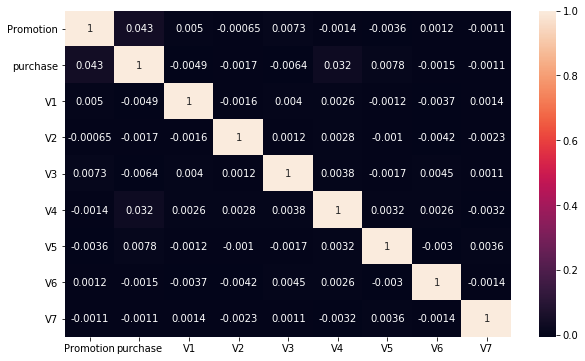

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(train_data.iloc[:,1:].corr(), annot=True);

There's low (linear) correlation between features and target variable.

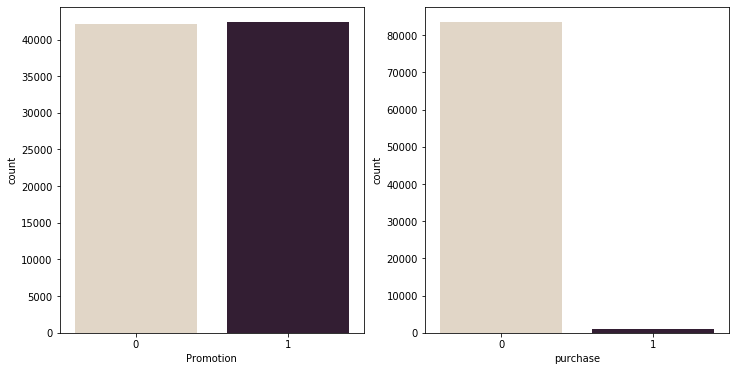

In [8]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.countplot(x="Promotion", palette="ch:.25", data=train_data, ax=axs[0])
sns.countplot(x="purchase", palette="ch:.25", data=train_data, ax=axs[1]);

- Highly imbalanced dataset (we want to predict whether customer purchases product). 
- The promotion was applied to half of the customers.

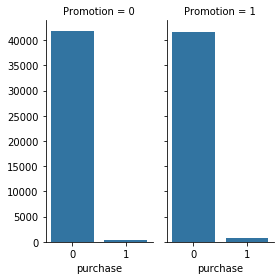

In [9]:
g = sns.FacetGrid(train_data, col="Promotion", height=4, aspect=.5)
g.map(sns.countplot, "purchase", order=[0,1]);

Purchases for group with promotion is a bit higher than without promotion (mean from 0.007 to 0.017), suggesting possible positive effect in sales. We'll analyze if this is statistically significant later.

In [10]:
g = train_data.groupby('Promotion')
no_promotion = g.get_group(0)
promotion = g.get_group(1)

In [11]:
print('Group without promotion')
display(no_promotion.describe())
print('Group with promotion')
display(promotion.describe())

Group without promotion


,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
count,42170.000000,42170.0,42170.000000,42170.000000,42170.000000,42170.000000,42170.000000,42170.000000,42170.000000,42170.000000
mean,63094.836661,0.0,0.007565,1.496277,29.976876,-0.007099,1.680270,2.330638,2.501565,1.702205
std,36537.629680,0.0,0.086646,0.868229,4.996765,1.002915,0.466377,0.842093,1.117431,0.457294
min,1.000000,0.0,0.000000,0.000000,8.939305,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31528.250000,0.0,0.000000,1.000000,26.608910,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62922.000000,0.0,0.000000,1.000000,29.969732,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94893.750000,0.0,0.000000,2.000000,33.354970,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,0.0,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


Group with promotion


,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
count,42364.000000,42364.0,42364.000000,42364.000000,42364.000000,42364.000000,42364.000000,42364.000000,42364.000000,42364.000000
mean,62847.675385,1.0,0.017019,1.505028,29.970338,0.007446,1.678949,2.324662,2.504225,1.701185
std,36299.420024,0.0,0.129344,0.868226,5.024443,0.998020,0.466886,0.840242,1.117279,0.457744
min,8.000000,1.0,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31387.500000,1.0,0.000000,1.000000,26.571116,-0.818772,1.000000,2.000000,2.000000,1.000000
50%,62717.000000,1.0,0.000000,2.000000,29.989227,0.047006,2.000000,2.000000,3.000000,2.000000
75%,93960.500000,1.0,0.000000,2.000000,33.332278,0.826206,2.000000,3.000000,4.000000,2.000000
max,126181.000000,1.0,1.000000,3.000000,49.823708,1.691984,2.000000,4.000000,4.000000,2.000000


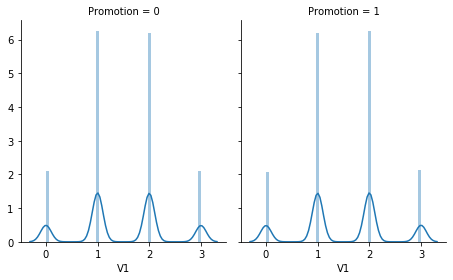

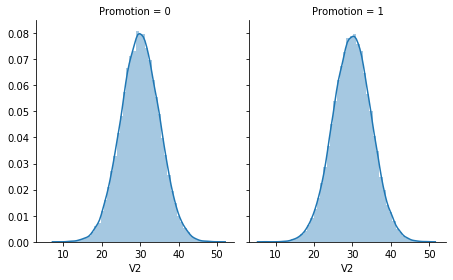

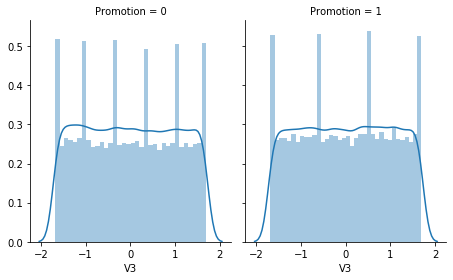

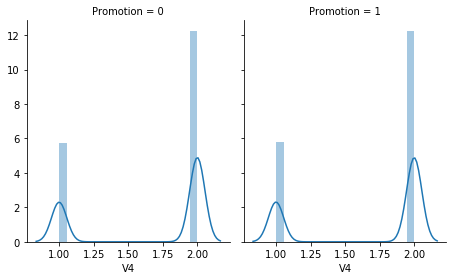

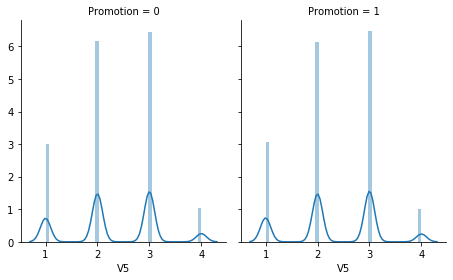

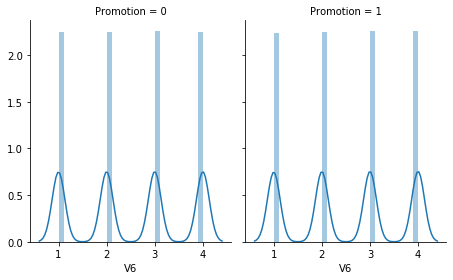

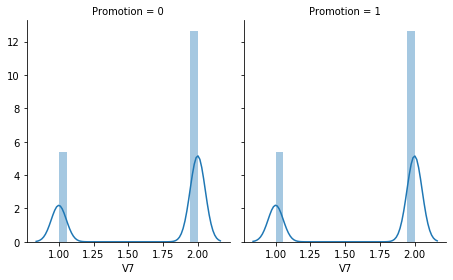

In [12]:
for col in train_data.iloc[:,3:].columns:
    g = sns.FacetGrid(train_data, col="Promotion", height=4, aspect=.8)
    g.map(sns.distplot, col);

Distributions for promotions look similar indicating that groups of customers (customers who received the promotion and those who didn't) were well split ramdomly. This indicates that the sampling was well done (the invariant metrics were similar between control group and experimental group).

##### How promotion affected purchases? Users that received promotions and bought products were similar (features are similar)?

Promotion = 0


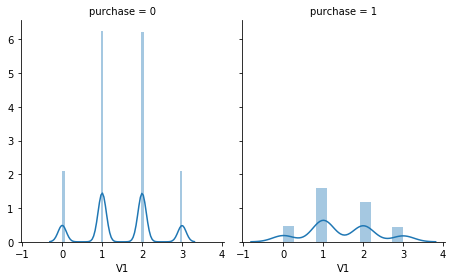

Promotion = 1


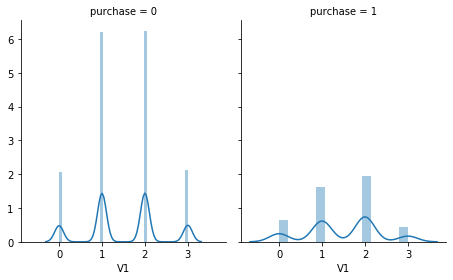

Promotion = 0


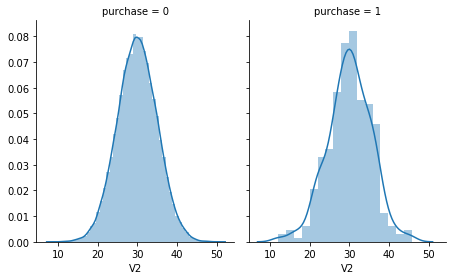

Promotion = 1


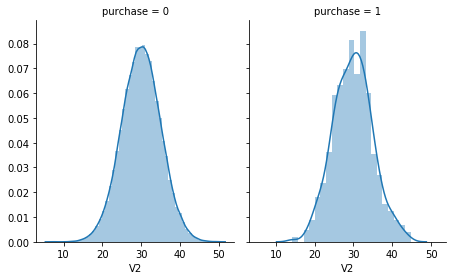

Promotion = 0


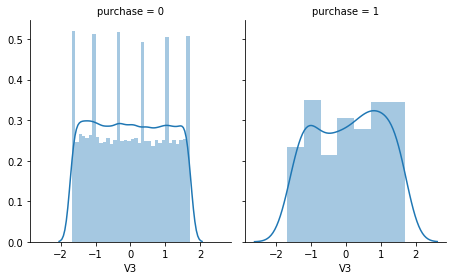

Promotion = 1


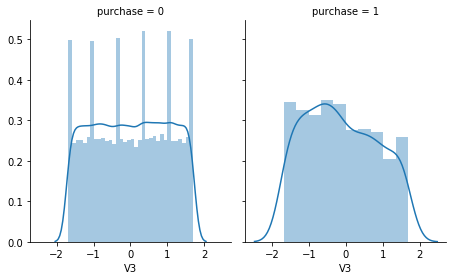

Promotion = 0


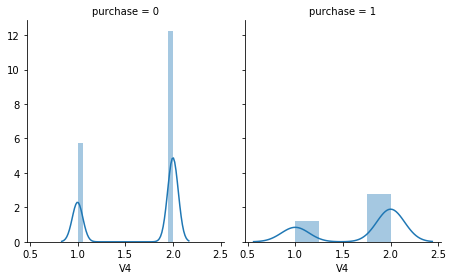

Promotion = 1


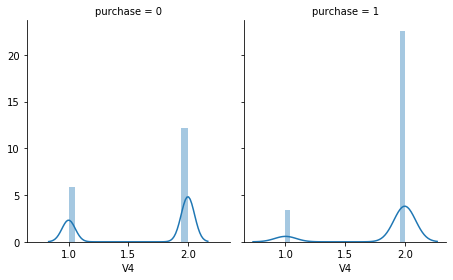

Promotion = 0


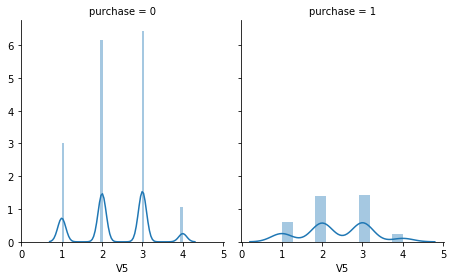

Promotion = 1


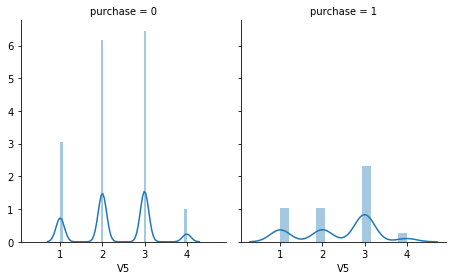

Promotion = 0


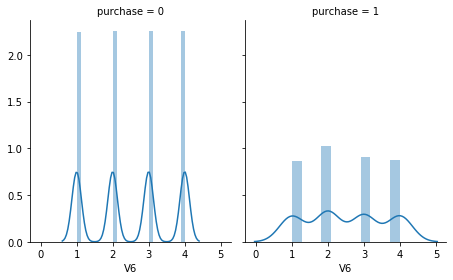

Promotion = 1


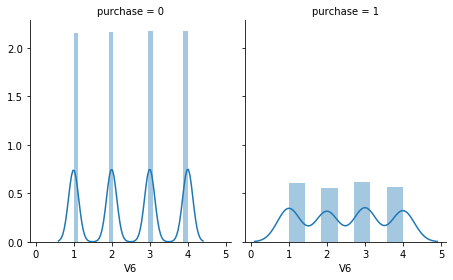

Promotion = 0


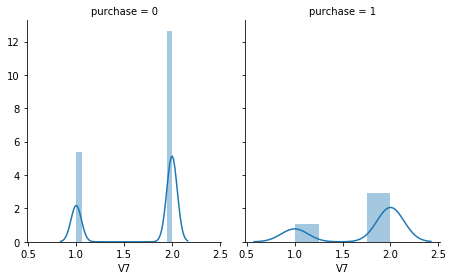

Promotion = 1


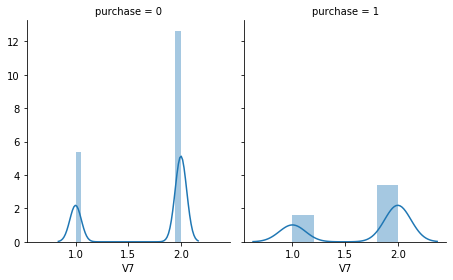

In [15]:
for col in train_data.iloc[:,3:].columns:
    for prom, data in enumerate([no_promotion, promotion]):
        print(f'Promotion = {prom}')
        g = sns.FacetGrid(data, col="purchase", height=4, aspect=.8)
        g.map(sns.distplot, col, norm_hist=True)
        plt.show()

Aparently users who purchased (`purchased=1`) have similar distibutions shapes of features (V1-V7). The same holds for users who didn't purchase (`purchased=0`), with similar distribution shapes.

However if they received a promotion, it appeared to have affect some features:
E.g. the feature V4 of users who have purchased (`purchased=1`), when receiving a promotion (`Promotion = 1`), more ocurrences of `V4=2.0` happened. This indicates a positive effect on this feature.

##### What is the IRR and NIR?

In [58]:
def calculate_irr(df):
    '''
    Function receives pandas dataframe with data from treatment and control groups and 
    calculates Incremental Response Rate (IRR).
    
    Parameters
    ----------
    df : Pandas dataframe with columns 'Promotion' and 'purchase'

    Returns
    -------
    irr : float for IRR 
    
    '''
    g = df.groupby('Promotion')
    no_promotion = g.get_group(0)
    promotion = g.get_group(1)
    
    irr = promotion['purchase'].mean() - no_promotion['purchase'].mean()
    
    return irr

def calculate_nir(df):
    '''
    Function receives pandas dataframe with data from treatment and control groups and 
    calculates Net Incremental Revenue (NIR).
    
    Parameters
    ----------
    df : Pandas dataframe with columns 'Promotion' and 'purchase'

    Returns
    -------
    irr : float for NIR 
    
    '''
    g = df.groupby('Promotion')
    no_promotion = g.get_group(0)
    promotion = g.get_group(1)
    purch_treat = np.count_nonzero(promotion['purchase'])
    cust_treat = promotion['purchase'].count()
    purch_ctrl = np.count_nonzero(no_promotion['purchase'])
    
    nir = (10*purch_treat - 0.15*cust_treat) - 10*purch_ctrl
    
    return nir

In [59]:
irr = calculate_irr(train_data)
nir = calculate_nir(train_data)

In [60]:
print("- Mean of purchases, when comparing the 2 groups (Promotion and No-Promotion) went from %0.4f to %0.4f" % (no_promotion['purchase'].mean(), promotion['purchase'].mean()))
print("- IRR was %0.4f" % (irr))
print("- NIR was %0.4f" % (nir))

- Mean of purchases, when comparing the 2 groups (Promotion and No-Promotion) went from 0.0076 to 0.0170
- IRR was 0.0095
- NIR was -2334.6000


One way to think about this metrics is how well a random model performs on the data.
For a model the predicts that 50% will buy and 50% won't buy, we send promotions to those we think will buy (50% in this example). Then, we get a IRR of 0.0095 and a NIR of -2334.6000

##### Is the difference in means of purchases between group who haven't received promotion from the group who have received statistically significant? 

In [ ]:
# TODO: perform statistical test to see wheter diff in means is significant
# try permutation test or bootstrapping (non-parametric tests)

def perform_test(df):

In [ ]:
perform_test(train_data)

#### Modeling
First we are going to try XGBoost for classification (we could use and test other models). 
We are going to use default hyperparameters.

In [ ]:
# TODO: split train, test, 
#fit XGBoost

In [ ]:
# see feature importances

Calculating the IRR and NIR for our model, assuming threshold of 0.5 (if XGBoost predicts greater than 0.5 it is a purchase, otherwise not purchase):

In [ ]:
#TODO: compute IRR, NIR

In [ ]:
#TODO: predict outputing probabilities
predictions_prob = 

Let's evaluate multiple thresholds, and plot the metric that optmizes IRR and NIR:

In [ ]:
# TODO: our promotion group is with individuals we predicted will purchase.
#       those we predict won't purchase 

def show_irr_nir_curves(predictions_prob):
    '''
    Function plots how IRR and NIR change with respect to multiple thresholds in preditions.
    
    Parameters
    ----------
    predictions_prob : list of predictions

    Returns
    -------
    None
    '''
    thresholds = range(0.01, 1, 0.01):
    irrs = []
    nirs = []
    for thres in thresholds:
        pred = np.where(predictions_prob>thres, 1, 0)
        irrs.append(calculate_irr(pred))
        nirs.append(calculate_nir(pred))

    fig, axs = plt.subplots(1,2, figsize=(12,6))
    ax[0].plot(thresholds, irrs)
    ax[0].axvline(np.argmax(irrs))
    ax.set_xlabel('Threshold');
    ax.set_ylabel('IRR'); 
    ax[0].set_title('IRR analysis for multiple thresholds')
    ax[1].plot(thresholds, nirs)
    ax[1].axvline(np.argmax(nirs))
    ax.set_xlabel('Threshold');
    ax.set_ylabel('NIR'); 
    ax[1].set_title('NIR analysis for multiple thresholds')


In [ ]:
show_irr_nir_curves(predictions_prob)

Now, let's try to improve our model, by fixing the imbalance between numer of purchasers and non-pruchasers.
Let's fit XGBoost with dafult hyperparameters again.

In [ ]:
# TODO: use SMOTE
# TODO: split train, test, 
#fit XGBoost

In [ ]:
# see feature importances

The new IRR and NIR for our model.

In [ ]:
#TODO: compute IRR, NIR

In [ ]:
#TODO: predict outputing probabilities
new_predictions_prob = 

In [ ]:
show_irr_nir_curves(new_predictions_prob)

##### Checking again if the difference in means of purchases between new groups is statistically significant:
- New group of those who have received promotion are individuals who our model predicted they would buy
- New group of those who haven't received promotion are individuals who our model predicted they wouldn't buy

In [ ]:
perform_test(df):

#### Defining promotion Strategy

In [ ]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should receive a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    
    

    return promotion

In [ ]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

In [ ]:
# Results analysis, better or worse than benchmark

Here, we could improve even more our model by dealing with the outliers in feature V4, trying other techniques for dealing with imbalances, perform hyperparameter optimization (with Random Search, Grid Search or some Bayesian method, for example), try other models (Logistic Regression, SVM, etc.) and so on.

In addition, after deploying new model we could analyze whether with our model performs better by doing online tests.
We could again create control and treatment groups as was done before and check if the difference in means of purchases between groups is statiscally significant